In [1]:
import lightkurve as lk
import giants as g
import numpy as np

In [2]:
tic = 181862539

In [3]:
lcc = g.Giant().from_eleanor(tic)

Using the brightest 727 targets.
Creating light curve for target 181862539 for sectors [10].


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
100%|██████████| 1211/1211 [00:23<00:00, 50.51it/s]


In [4]:
# sneaky nonsense
lc5 = lk.search_lightcurvefile('k2-199')[0].download()

In [5]:
lc = lcc[1]
lc.time_format = 'jd'
lc.quality = np.ones(len(lc.time), dtype='int')
lc.cadenceno = lc5.cadenceno[:len(lc.time)]

In [7]:
lc.remove_outliers().interact_bls('localhost:8888')

In [11]:
period = 1.57141
t0 = .927

In [16]:
lc = lc[100:]

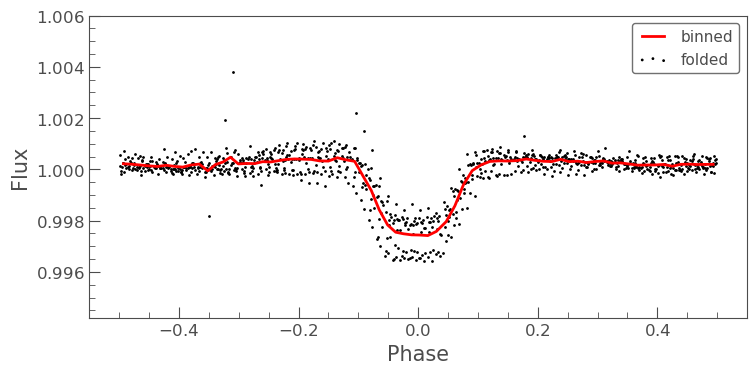

In [29]:
ax = lc.flatten().remove_outliers().fold(period, t0).scatter(c='k', label='folded')
lc.flatten().remove_outliers().fold(period, t0).bin().plot(ax=ax, c='r', label='binned', lw=2)

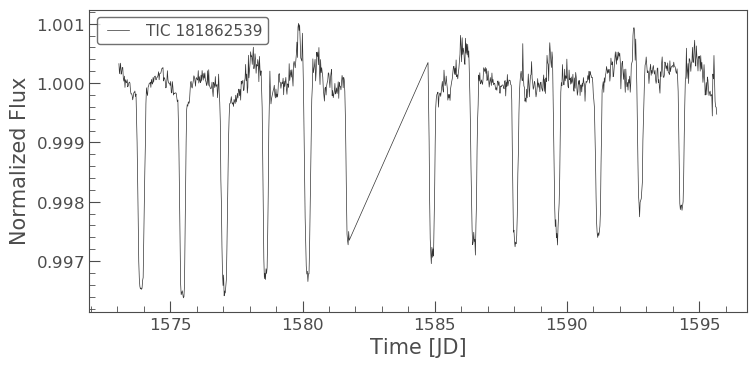

In [30]:
lc.remove_outliers().flatten().plot(label=f'TIC {tic}')

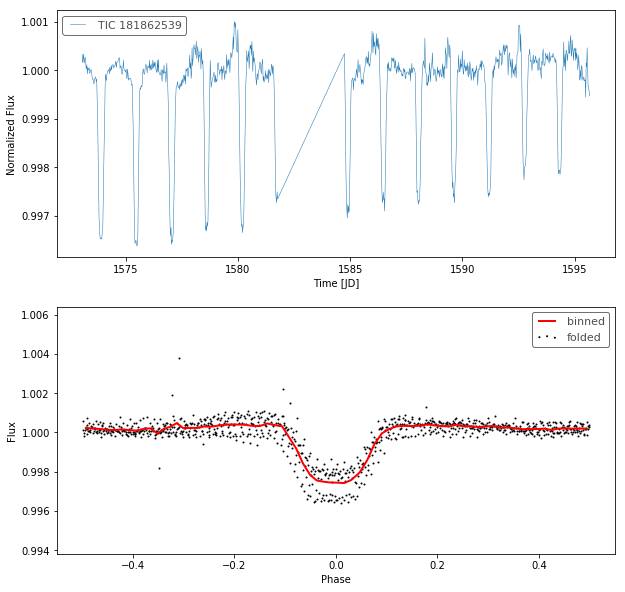

In [33]:
import matplotlib.pyplot as pl
fig, ax = pl.subplots(2, figsize=(10,10))
lc.remove_outliers().flatten().plot(ax=ax[0], label=f'TIC {tic}')
lc.flatten().remove_outliers().fold(period, t0).scatter(ax=ax[1], c='k', label='folded')
lc.flatten().remove_outliers().fold(period, t0).bin().plot(ax=ax[1], c='r', label='binned', lw=2)